In [1]:
#Module imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import re 
import seaborn as sns 
import os 

In [2]:
##Preprocessing##
#Read bpm and mcseed information 
formatted_dir = "formatted_input"
bpm_path = "{0}/19isolates_BPM.csv".format(formatted_dir)
mcseed_path = "{0}/19isolates_mcseed_pathwaycomplete.csv".format(formatted_dir)
bpm_df = pd.read_csv(bpm_path)
mcseed_df = pd.read_csv(mcseed_path)
#Process GO annotations from semicolon separated string into list of entries for columns Functional Pathway and Phenotype
for col in ["Functional pathway", "Phenotype"]:
    mcseed_df.loc[:,col] = mcseed_df.loc[:,col].str.split(";")
#Set indices: BPM -> Isolate name; mcseed -> Locus tag; TPM -> target_id (locus)
bpm_df.set_index("Isolate name",inplace=True)
mcseed_df.set_index("Locus tag",inplace=True)

bpm_df = bpm_df.transpose().drop(index="# functions")

#Make helper dictionaries mapping strain full names to abbreviations and 
#shortened abbreviations (first 3 char) to full names
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
STRAIN_TAGS = dict(zip(bpm_df.columns,STRAIN_ABBREVS))
SHORT_ABBREVS = [abbrev[:3] for abbrev in STRAIN_ABBREVS]
STRAIN_ABBREV_TO_FULL = dict(zip(SHORT_ABBREVS, bpm_df.columns))

for strain in STRAIN_TAGS:
    strain_abbrev = STRAIN_TAGS[strain]
    if not (strain == "Blautia obeum Bg7063_SSTS2015" and strain_abbrev == "Rob"): 
        assert(strain[0] == strain_abbrev[0])

#BPM Summary statistics 
print("BPM=1 pathways by strain")
print(bpm_df.sum())
print("Total BPM=1 pathways: {0}".format(bpm_df.sum().sum()))

BPM=1 pathways by strain
Isolate name
Bifidobacterium breve Bgsng463_m5_93            46
Bifidobacterium catenulatum Bgsng468_m22_84     44
Bifidobacterium longum infantis 40721_2D9_SN    50
Blautia luti Bg7063                             53
Blautia obeum Bg7063_SSTS2015                   53
Dorea formicigenerans Bg7063                    43
Dorea longicatena Bg7063                        45
Enterococcus_avium_Bang_SAM2_39_S1              57
Escherichia coli PS_131_S11                     77
Faecalibacterium prausnitzii Bg7063             43
Lactococcus garvieae Bang155_08_4B6_JG2017      32
Ligilactobacillus ruminis ATCC_25644            33
Mitsuokella multacida DSM_20544                 45
Prevotella copri PS_131_S11                     49
Prevotella stercorea DSM_18206                  29
Ruminococcus gnavus M8243_3A11_TMS_2014         63
Ruminococcus torques Bg7063                     50
Streptococcus gallolyticus PS_064_S07           42
Streptococcus pasteriuanus Bang_SAM2_39_S1  

In [3]:
def vc_strain_locus_tag(expr_df,mcseed_df):
    """Returns a DataFrame indexed on locus tags for each strain, containing columns: 
        "Filtered Loci" - number of loci corresponding to that locus tag (ie loci per strain)
        "Strain" - full strain name corresponding to locus tag 
        :param pd.DataFrame expr_df: DataFrame indexed by ORFs containing (transformed) expression data, columns
        are samples 
        :param pd.DataFrame mcseed_df: DataFrame containing mcSEED annotations for loci, not necessarily for 
        all loci in expr_df 
    """
    vc_by_strain_locus_tag = expr_df.index.str.extract(r'(\w+)_\d+',expand=False).value_counts()
    vc_by_strain_locus_tag.drop("ROSSTS7063_a2",inplace=True)
    locus_tag_strains = [mcseed_df.loc[mcseed_df.index.str.contains(lt),"Isolate name"].values[0] 
                             for lt in vc_by_strain_locus_tag.index] #if lt != "ROSSTS7063_a2"]
    locus_vc_df = pd.DataFrame(index=vc_by_strain_locus_tag.index,columns=["Filtered Loci","Strain"])
    locus_vc_df.loc[:,"Filtered Loci"] = vc_by_strain_locus_tag
    locus_vc_df.loc[:,"Strain"] = locus_tag_strains
    return locus_vc_df

In [17]:
transformed_data_dir = "formatted_output/transformed/thr3_prev0.3_cecal"
param_str = re.match(r"formatted_output\/transformed\/([\w_\.]+)",transformed_data_dir).groups()[0]
figures_dir = "figures/{0}".format(param_str)
os.makedirs(figures_dir)

filt_tpm_fpath = "{0}/filt_merged_tpm.csv".format(transformed_data_dir)
filt_vst_fpath = "{0}/filt_merged_vst.csv".format(transformed_data_dir)
filt_log_fpath = "{0}/filt_merged_log.csv".format(transformed_data_dir)
filt_rlog_fpath = "{0}/filt_merged_rlog.csv".format(transformed_data_dir)
filt_tpm_df = pd.read_csv(filt_tpm_fpath,index_col=0)
filt_vst_df = pd.read_csv(filt_vst_fpath,index_col=0)
filt_log_df = pd.read_csv(filt_log_fpath,index_col=0)
filt_rlog_df = pd.read_csv(filt_rlog_fpath,index_col=0)

DATASET = "rlog"
if DATASET == "rlog":
    filt_expr_df = filt_rlog_df
    agg_method = "mean"
elif DATASET == "log":
    filt_expr_df = filt_log_df
    agg_method = "nonzero_mean"
elif DATASET == "vst":
    filt_expr_df = filt_vst_df
    agg_method = "nonzero_mean"

locus_vc_df = vc_strain_locus_tag(filt_expr_df,mcseed_df)
print(len(filt_expr_df))

20282


In [5]:
#Check phenotype mapping for strains 
low_filt_count = locus_vc_df.loc[locus_vc_df["Filtered Loci"] < 100,"Strain"]
all_filt_counts = locus_vc_df.loc[:,"Strain"]
#for loc_tag, strain in low_filt_count.iteritems():
mcseed_counts_df = locus_vc_df.copy()
for loc_tag, strain in all_filt_counts.iteritems():
    filt_locs = filt_expr_df.loc[filt_expr_df.index.str.contains(loc_tag),:]
#     display(filt_locs)
    assert(len(filt_locs) == locus_vc_df.loc[loc_tag,"Filtered Loci"])
    filt_locs_idx = filt_locs.index
    mcseed_present = 0 
    mcseed_absent = 0 
    for locus in filt_locs_idx:
        try: 
            mcseed_row = mcseed_df.loc[locus,:]
            mcseed_present += 1
        except KeyError as e:
            mcseed_absent += 1
    mcseed_counts_df.loc[loc_tag,"mcseed_present"] = mcseed_present
    mcseed_counts_df.loc[loc_tag,"mcseed_absent"] = mcseed_absent
#     print("mcseed Present: {0}; mcseed Absent: {1}".format(mcseed_present,mcseed_absent))
    assert(mcseed_present+mcseed_absent == len(filt_locs))
mcseed_counts_df.loc[:,"mcseed_present"] = mcseed_counts_df.loc[:,"mcseed_present"].astype(int)
mcseed_counts_df.loc[:,"mcseed_absent"] = mcseed_counts_df.loc[:,"mcseed_absent"].astype(int)
display(mcseed_counts_df)

,Filtered Loci,Strain,mcseed_present,mcseed_absent
GJBELKAJ,2870,Ruminococcus gnavus M8243_3A11_TMS_2014,407,2463
HIAFFLEM,2860,Blautia obeum Bg7063_SSTS2015,377,2483
NJCFFJJN,2824,Prevotella copri PS_131_S11,282,2542
HMLHAAEP,2480,Escherichia coli PS_131_S11,269,2211
AKLJOBCP,1891,Enterococcus_avium_Bang_SAM2_39_S1,186,1705
ONMCJBAG,1851,Mitsuokella multacida DSM_20544,204,1647
NBCBLOMG,1230,Prevotella stercorea DSM_18206,85,1145
OOAPABDJ,1127,Dorea longicatena Bg7063,122,1005
LDOIJNDB,606,Streptococcus pasteriuanus Bang_SAM2_39_S1,93,513
NNMNEBCK,516,Bifidobacterium catenulatum Bgsng468_m22_84,93,423


In [18]:
#Function version of sample Pht x strainate DataFrames 
def per_sample_pht_aggregation(expr_df, bpm_df, mcseed_df,agg_method="nonzero_mean",verbose=False):
    """Generates a dictionary mapping sample names to DataFrame objects where index = phenotypes, 
        columns = strainates, and individual values are pathway aggregated expression (currently implemented
        as mean of non-minimum values ~ i.e. non zero transcript (vst or log transformed) expression)
        expr_df: DataFrame with index of gene loci and columns of samples. Can be tpm/prevalence filtered
                 as well as tpm, vst, or log transformed
        bpm_df: DataFrame with index of phenotypes and columns of strainates 
        mcseed_df: DataFrame with index of locus tags and containing mcSEED annotation information for those loci,
        including the column Phenotype which must contain lists of Pht abbreviations corresponding to the phenotypes
        in bpm_df. 
        agg_methods: {nonzero_mean, ...}; nonzero_mean - drops minimum expression value (ie 0 or vst/log 
        transformed 0s) before aggregating phenotype expression by mean 
    """
    sample_pht_expr_dfs = {}
    for sample in expr_df:
        sample_pht_expr_dfs[sample] = bpm_df.copy()
    min_expr = expr_df.values.min()
    if verbose: 
        print("Min expression value: {0}".format(min_expr))
    
    for strain in bpm_df:
        bpm_expr_col = bpm_df.loc[:,strain]
        strain_mcseed_df = mcseed_df.loc[mcseed_df["Isolate name"]==strain]
        if verbose: 
            print("Isolate: {1} \nComplete Pathways: {0}".format(sum(bpm_expr_col),strain))
        for pht,entry in bpm_expr_col.iteritems():
            if entry == 1:
                pht_strain_mcseed_df = strain_mcseed_df.loc[strain_mcseed_df["Phenotype"].apply(lambda phts_list:pht in phts_list)]
                try:
                    pht_strain_expr_df = expr_df.loc[pht_strain_mcseed_df.index[pht_strain_mcseed_df.index.isin(expr_df.index)]]
                    if agg_method == "nonzero_mean":
                        ##Include this line for dropping 0s (or transformed 0s) from phenotype averages##
                        pht_strain_expr_df = pht_strain_expr_df.replace(min_expr,np.nan)
                    elif agg_method == "mean":
                        pass #Retain (transformed) 0s in phenotype aggregation; use this option if using rlog 
                        #data since rlog does not stably transform all 0 expressions to one min value
                    for sample in pht_strain_expr_df:
                        sample_pht_expr_df = sample_pht_expr_dfs[sample]
                        pht_strain_tpm = pht_strain_expr_df[sample]
#                         pht_agg = 1 #Same as bpm_df 
                        pht_agg = pht_strain_tpm.mean()
                        sample_pht_expr_df.loc[pht,strain] = pht_agg
                except KeyError as e:
                    #Occurs when none of pht loci are in expr_df; aggregated expression = np.nan
                    pht_agg = np.nan
                    for sample in expr_df: 
                        sample_pht_expr_df = sample_pht_expr_dfs[sample]
                        sample_pht_expr_df.loc[pht,strain] = pht_agg
    return sample_pht_expr_dfs

#TODOs: 1. Function for pathway aggregated SVD data formatting
def pht_aggregation_bpm1(expr_df, bpm_df, mcseed_df,agg_method="nonzero_mean",
                         verbose=False,reorder_columns="cecal_1C2A",pathway_minimum_fill="na"):
    """Generates a single DataFrame objects where index = phenotypes for which BPM=1 grouped by taxa, 
        columns = strainates, and individual values are pathway aggregated expression (currently implemented
        as mean of non-minimum values ~ i.e. non zero transcript (vst or log transformed) expression)
        expr_df: DataFrame with index of gene loci and columns of samples. Can be tpm/prevalence filtered
                 as well as tpm, vst, or log transformed
        bpm_df: DataFrame with index of phenotypes and columns of strainates 
        mcseed_df: DataFrame with index of locus tags and containing mcSEED annotation information for those loci,
        including the column Phenotype which must contain lists of Pht abbreviations corresponding to the phenotypes
        in bpm_df. 
        agg_methods: {"nonzero_mean","mean"}; nonzero_mean - drops minimum expression value (ie 0 or vst/log 
        transformed 0s) before aggregating phenotype expression by mean; mean - retain minimum expression value 
        in aggregated phenotypes 
        pathway_minimum_fill: {"min","na"}: if an entire phenotype has aggregated expression equal to min_expr 
        (ie no loci in phenotype are expressed), determines fill value. Use min for subsequent SVD, na for 
        aggregated phenotype expression visualization. 
        
    """
    all_pht_df = pd.DataFrame(columns=expr_df.columns)
    min_expr = expr_df.values.min()
    print("Min expression value: {0}".format(min_expr))
    
    for strain in bpm_df:
        bpm_expr_col = bpm_df.loc[:,strain]
        strain_mcseed_df = mcseed_df.loc[mcseed_df["Isolate name"]==strain]
        if verbose:
            print("Isolate: {1} \nComplete Pathways: {0}".format(sum(bpm_expr_col),strain))
        bpm1_entries = bpm_expr_col[bpm_expr_col==1]
        strain_phts = ["{0}_{1}".format(STRAIN_TAGS[strain],pht) for pht in bpm1_entries.index]
        strain_pht_agg_df = pd.DataFrame(index=strain_phts,columns=expr_df.columns)
        for pht in bpm1_entries.index:
            pht_strain_mcseed_df = strain_mcseed_df.loc[strain_mcseed_df["Phenotype"].apply(lambda phts_list:pht in phts_list)]
            try:
                pht_strain_expr_df = expr_df.loc[pht_strain_mcseed_df.index[pht_strain_mcseed_df.index.isin(expr_df.index)]]
                if agg_method == "nonzero_mean":
                    ##Include this line for dropping 0s (or transformed 0s) from phenotype averages##
                    pht_strain_expr_df = pht_strain_expr_df.replace(min_expr,np.nan)
                elif agg_method == "mean":
                    pass #Retain (transformed) 0s in phenotype aggregation 
                strain_pht_str = "{0}_{1}".format(STRAIN_TAGS[strain],pht)
                sample_pht_means = pht_strain_expr_df.mean(axis=0)
                strain_pht_agg_df.loc[strain_pht_str,:] = sample_pht_means
            except KeyError as e:
                #Occurs when none of pht loci are in expr_df; aggregated expression = np.nan for pht 
                pht_agg = np.nan
                strain_pht_agg_df.loc[strain_pht_str,:] = pht_agg
        all_pht_df = pd.concat([all_pht_df,strain_pht_agg_df])
    #column reordering 
    if reorder_columns:
        cols_1C_arr, cols_2A_arr = [all_pht_df.columns.str.contains(tag) for tag in ["1C","2A"]] #boolean arrays 
        cols_1C, cols_2A = [all_pht_df.columns[cols] for cols in [cols_1C_arr,cols_2A_arr]]#filtered column lists 
        cols_1C_cecal_arr, cols_1C_ileal_arr = [cols_1C.str.contains(tag) for tag in ["cecal","ileal"]] #boolean_arrays
        cols_1C_cecal, cols_1C_ileal = [cols_1C[cols_1C_cecal_arr],cols_1C[cols_1C_ileal_arr]] #filtered columns
        cols_2A_cecal_arr, cols_2A_ileal_arr = [cols_2A.str.contains(tag) for tag in ["cecal","ileal"]] #boolean arrays
        cols_2A_cecal, cols_2A_ileal = [cols_2A[cols_2A_cecal_arr],cols_2A[cols_2A_ileal_arr]]
        if reorder_columns=="cecal_1C2A":
            reordered_cols = pd.Index(list(cols_1C_cecal)+list(cols_2A_cecal)+list(cols_1C_ileal)+list(cols_2A_ileal))
        all_pht_df = all_pht_df.loc[:,reordered_cols].astype("float")
    #Minimum aggregated phenotype value handling - retain min values for PCA/SVD or na for heatmap 
    #visualization purposes
    if pathway_minimum_fill == "na":
        all_pht_df.replace(min_expr,np.nan,inplace=True)
        if verbose: 
            print("Replacing minimum expression value ({0}) for aggregated phenotypes with np.nan".format(min_expr))
    elif pathway_minimum_fill == "min":
        all_pht_df.replace(np.nan,min_expr,inplace=True)
        if verbose:
            print("Replacing np.nan aggregated phenotypes with minimum expression value: {0}".format(min_expr))
    return all_pht_df
#TODO: 2. Function for BPM=1 filtering of expr_df for individual transcript SVD
def bpm_filter_expr_data(expr_df,bpm_df,mcseed_df,verbose=False,reorder_columns="cecal_1C2A"):
    """Return a filtered version of expr_df in original row order from expr_df containing only loci 
    which map to a complete phenotype (BPM=1)
    expr_df: DataFrame with index of gene loci and columns of samples. Can be tpm/prevalence filtered
                 as well as tpm, vst, or log transformed
    bpm_df: DataFrame with index of phenotypes and columns of strainates 
    mcseed_df: DataFrame with index of locus tags and containing mcSEED annotation information for those loci,
        including the column Phenotype which must contain lists of Pht abbreviations corresponding to the phenotypes
        in bpm_df. 
    """
    bpm_filt_expr_df = pd.DataFrame(columns=expr_df.columns)
    for strain in bpm_df:
        bpm_expr_col = bpm_df.loc[:,strain]
        strain_mcseed_df = mcseed_df.loc[mcseed_df["Isolate name"]==strain]
        if verbose:
            print("Isolate: {1} \nComplete Pathways: {0}".format(sum(bpm_expr_col),strain))
        bpm1_entries = bpm_expr_col[bpm_expr_col==1]
        for pht in bpm1_entries.index:
            pht_strain_mcseed_df = strain_mcseed_df.loc[strain_mcseed_df["Phenotype"].apply(lambda phts_list:pht in phts_list)]
            try:
                pht_strain_expr_df = expr_df.loc[pht_strain_mcseed_df.index[pht_strain_mcseed_df.index.isin(expr_df.index)]]
                bpm_filt_expr_df = pd.concat([bpm_filt_expr_df,pht_strain_expr_df])
            except KeyError as e:
                pass
    #column reordering 
    if reorder_columns:
        cols_1C_arr, cols_2A_arr = [bpm_filt_expr_df.columns.str.contains(tag) for tag in ["1C","2A"]] #boolean arrays 
        cols_1C, cols_2A = [bpm_filt_expr_df.columns[cols] for cols in [cols_1C_arr,cols_2A_arr]]#filtered column lists 
        cols_1C_cecal_arr, cols_1C_ileal_arr = [cols_1C.str.contains(tag) for tag in ["cecal","ileal"]] #boolean_arrays
        cols_1C_cecal, cols_1C_ileal = [cols_1C[cols_1C_cecal_arr],cols_1C[cols_1C_ileal_arr]] #filtered columns
        cols_2A_cecal_arr, cols_2A_ileal_arr = [cols_2A.str.contains(tag) for tag in ["cecal","ileal"]] #boolean arrays
        cols_2A_cecal, cols_2A_ileal = [cols_2A[cols_2A_cecal_arr],cols_2A[cols_2A_ileal_arr]]
        n_1C_cecal, n_1C_ileal, n_2A_cecal, n_2A_ileal = [len(cols) for cols in [cols_1C_cecal,cols_1C_ileal,
                                                                                cols_2A_cecal,cols_2A_ileal]]
        if reorder_columns=="cecal_1C2A":
            reordered_cols = pd.Index(list(cols_1C_cecal)+list(cols_2A_cecal)+list(cols_1C_ileal)+list(cols_2A_ileal))
        bpm_filt_expr_df = bpm_filt_expr_df.loc[:,reordered_cols].astype("float")
    return bpm_filt_expr_df

Min expression value: -4.31353706976841


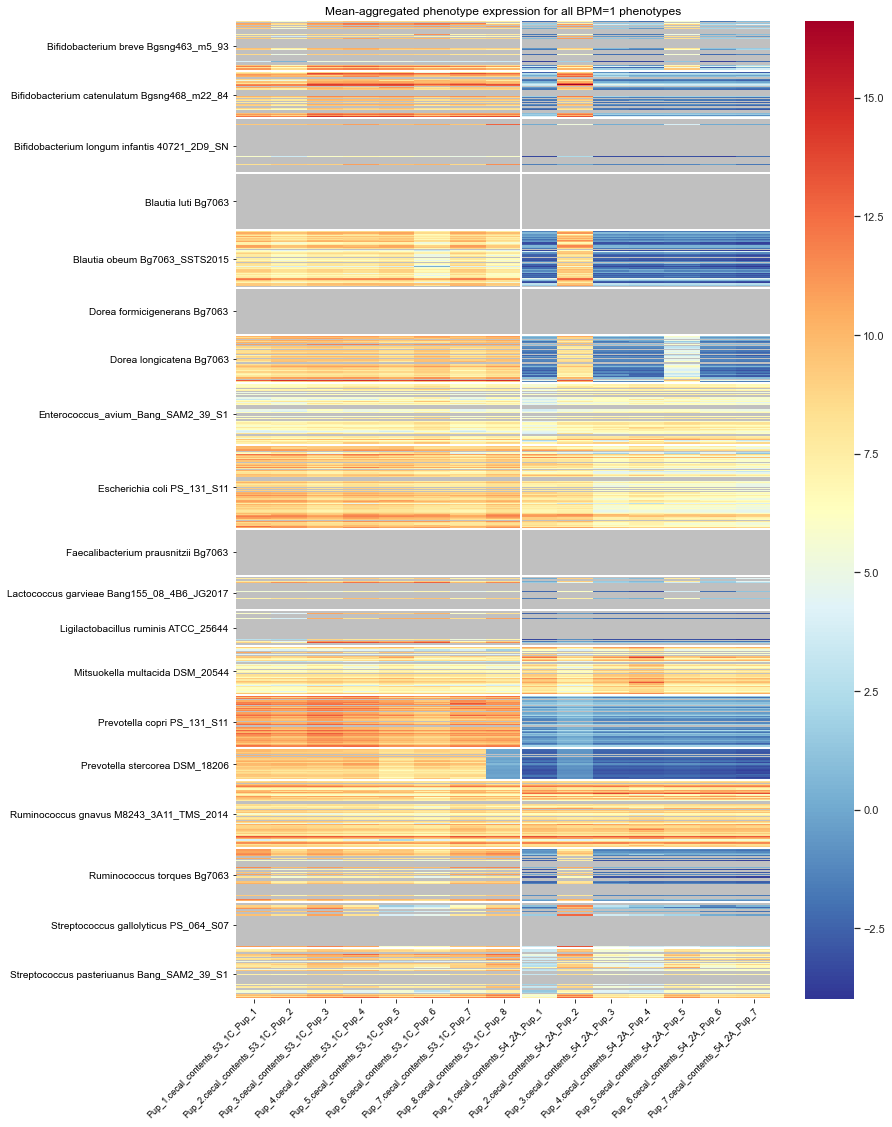

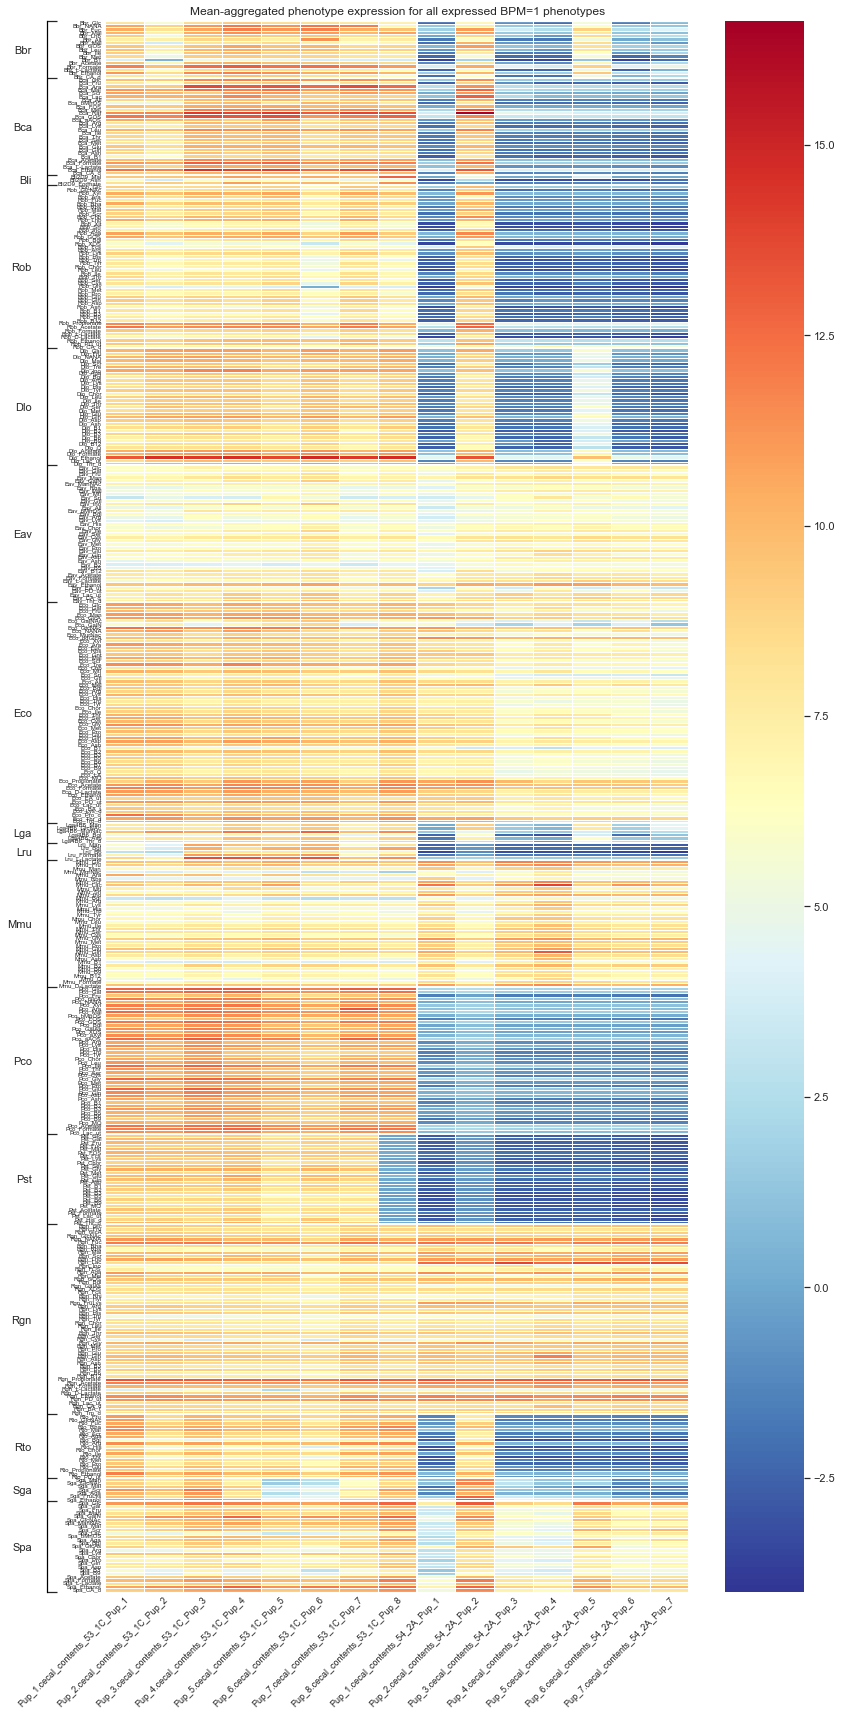

In [19]:
import matplotlib.ticker as ticker
from mpl_toolkits.axisartist.parasite_axes import SubplotHost

##log version##
# all_pht_df = pht_aggregation_bpm1(filt_expr_df,bpm_df,mcseed_df,agg_method=agg_method,
#                                  pathway_minimum_fill="na")
##rlog version##
all_pht_df = pht_aggregation_bpm1(filt_expr_df,bpm_df,mcseed_df,agg_method=agg_method,
                                 pathway_minimum_fill="na")

cols_1C_arr, cols_2A_arr = [all_pht_df.columns.str.contains(tag) for tag in ["1C","2A"]] #boolean arrays 
cols_1C, cols_2A = [all_pht_df.columns[cols] for cols in [cols_1C_arr,cols_2A_arr]]#filtered column lists 
cols_1C_cecal_arr, cols_1C_ileal_arr = [cols_1C.str.contains(tag) for tag in ["cecal","ileal"]] #boolean_arrays
cols_1C_cecal, cols_1C_ileal = [cols_1C[cols_1C_cecal_arr],cols_1C[cols_1C_ileal_arr]] #filtered columns
cols_2A_cecal_arr, cols_2A_ileal_arr = [cols_2A.str.contains(tag) for tag in ["cecal","ileal"]] #boolean arrays
cols_2A_cecal, cols_2A_ileal = [cols_2A[cols_2A_cecal_arr],cols_2A[cols_2A_ileal_arr]]
n_1C_cecal, n_1C_ileal, n_2A_cecal, n_2A_ileal = [len(cols) for cols in [cols_1C_cecal,cols_1C_ileal,
                                                                        cols_2A_cecal,cols_2A_ileal]]
#Uncondensed heatmap (all BPM=1 pathways without dropping those with missing expression data)
plot_uncondensed_heatmap = True
if plot_uncondensed_heatmap:
    fig = plt.figure(figsize=(12,18))
    fig.tight_layout()
    plt.title("Mean-aggregated phenotype expression for all BPM=1 phenotypes",fontsize=12)
    sns.set(font_scale=1.0)
    g = sns.heatmap(all_pht_df,cmap="RdYlBu_r",xticklabels=True,yticklabels=False)
    strain_bpm_complete_counts, total_bpm1 = bpm_df.sum(), bpm_df.sum().sum()
    strain_hline_pos,strain_label_pos = [],[]
    for strain,bpm_count in strain_bpm_complete_counts.iteritems():
        #position is top of block of strain phenotypes; top of heatmap is position 0  
        strain_hline_pos.append((strain_bpm_complete_counts.loc[:strain].sum()))
        strain_label_pos.append((strain_bpm_complete_counts.loc[:strain].sum())-bpm_count/2)
    cecal_ileal_vline = n_1C_cecal + n_2A_cecal
    g.vlines([cecal_ileal_vline],*g.get_ylim(),color="white",linewidth=3)
    arm_vlines = [n_1C_cecal,n_1C_cecal+n_1C_ileal+n_2A_cecal]
    g.vlines(arm_vlines,*g.get_ylim(),color="white",linewidth=2)
    g.hlines(strain_hline_pos,*g.get_xlim(),color="white",linewidth=2)

    g.set_yticks(strain_label_pos)
    g.set_yticklabels(bpm_df.columns)
    g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right', rotation_mode='anchor',fontsize=9)
    g.set_facecolor("#C0C0C0")
    plt.savefig("{0}/all_pht_log_heatmap.png".format(figures_dir), dpi=200, facecolor='w',bbox_inches="tight")

#Condensed heatmap (drop pathways missing expression data)
# from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(1,1, figsize=(12,24))
plt.subplots_adjust(right=0.75)

ax1.set_title("Mean-aggregated phenotype expression for all expressed BPM=1 phenotypes",fontsize=12)
sns.set(font_scale=1.0)
condensed_allpht_df = all_pht_df.dropna(axis=0,how="all")
sns.heatmap(condensed_allpht_df,cmap="RdYlBu_r",ax=ax1,xticklabels=True,yticklabels=True,linewidths=.5)#,xticklabels=False,yticklabels=False)#,xticklabels=True,yticklabels=True)

#Strain h-lines label and line positions/plotting 
condensed_bpm_counts = condensed_allpht_df.index.str.extract("^(\w\w\w).*",expand=False).value_counts(sort=False)
condensed_hline_pos, condensed_label_pos = [0],[]
for abbrev,count in condensed_bpm_counts.iteritems():
    condensed_hline_pos.append(condensed_bpm_counts.loc[:abbrev].sum())
    condensed_label_pos.append(condensed_bpm_counts.loc[:abbrev].sum()-count/2)
total_condensed = len(condensed_allpht_df)    

condensed_strains = condensed_bpm_counts.index #Abbreviated strain names

ax1.set_yticklabels(ax1.get_yticklabels(),fontsize =6)
#Vlines for cecal/ilea, study arms 1C/2A
cecal_ileal_vline = n_1C_cecal + n_2A_cecal
ax1.vlines([cecal_ileal_vline],*ax1.get_ylim(),color="white",linewidth=3)
arm_vlines = [n_1C_cecal,n_1C_cecal+n_1C_ileal+n_2A_cecal]
ax1.vlines(arm_vlines,*ax1.get_ylim(),color="white",linewidth=2)
#Hlines for strain counts
for hline_pos in condensed_hline_pos[1:-1]:
    ax1.axhline(hline_pos,*ax1.get_xlim(),color="white",linewidth=2)
#Rotate xlabels for samples, set facecolor to gray for highlighting np.nan pht cells 
ax1.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right', rotation_mode='anchor',fontsize=9)
ax1.set_facecolor("#C0C0C0")

# Second Y-axis for grouping strain labels 
ax2 = ax1.twinx()
ax2.yaxis.tick_left()
ax2.set_ylim(*ax1.get_ylim())
ax2.set_yticks(condensed_hline_pos)

ax2.yaxis.set_major_formatter(ticker.NullFormatter())
ax2.yaxis.set_minor_locator(ticker.FixedLocator(condensed_label_pos))
ax2.yaxis.set_minor_formatter(ticker.FixedFormatter(condensed_strains))
ax2.tick_params(which='minor', length=0,pad=15)
ax2.tick_params(which='major',length=10,direction="in") 

ax2.spines.left.set_position(("axes",-0.1))
ax2.spines.left.set_color('black')
#Hide ax1 ticks 
ax1.tick_params(axis=u'both', which=u'both',length=0)

fig.tight_layout()
plt.savefig("{0}/condensed_pht_log_heatmap.png".format(figures_dir), dpi=200, facecolor='w',bbox_inches="tight")

Min expression value: -4.31353706976841


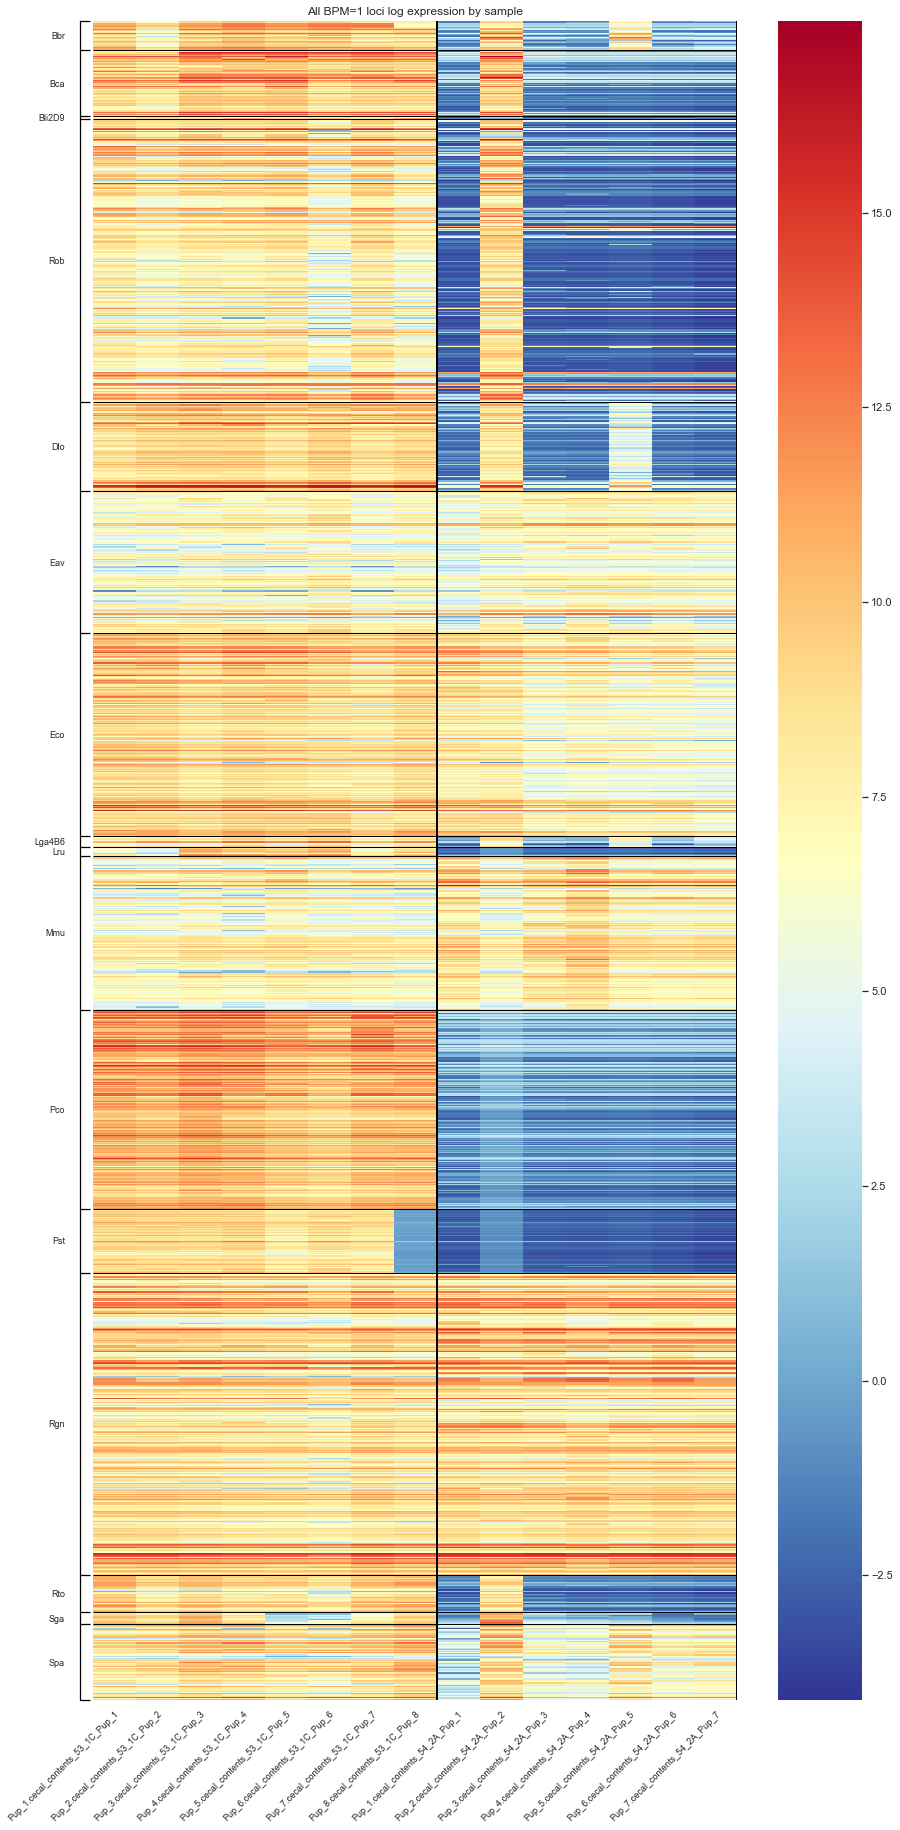

In [25]:
bpm_filt_expr_df = bpm_filter_expr_data(filt_expr_df,bpm_df,mcseed_df)

bpm_filt_dir = "formatted_output/bpm_filtered/{0}".format(param_str)
if not os.path.exists(bpm_filt_dir):
    os.makedirs(bpm_filt_dir)

write_bpm_filt_tables = True
if write_bpm_filt_tables:
    bpm_filt_expr_df.to_csv("{0}/bpm_filt_log.csv".format(bpm_filt_dir))
    #Write non-na versions of aggregated phenotypes to csv 
#     all_pht_df = pht_aggregation_bpm1(filt_expr_df,bpm_df,mcseed_df,agg_method="agg_method,
#                                  pathway_minimum_fill="min")#log version
    all_pht_df = pht_aggregation_bpm1(filt_expr_df,bpm_df,mcseed_df,agg_method=agg_method,
                                 pathway_minimum_fill="min")#rlog version
    min_expr = filt_expr_df.values.min()
    #Drop rows where phenotype expression is min_expr in all samples for condensed_allpht_df 
    condensed_allpht_df = all_pht_df.loc[~(all_pht_df == min_expr).all(axis=1),:] 
    all_pht_df.to_csv("{0}/bpm1_agg_pht_log.csv".format(bpm_filt_dir)) 
    condensed_allpht_df.to_csv("{0}/condensed_agg_pht_log.csv".format(bpm_filt_dir))
    
    
plot_transcript_heatmap = True 
if plot_transcript_heatmap:
#     fig = plt.figure(figsize=(12,18))
    fig, ax1 = plt.subplots(1,1, figsize=(12,24))
    fig.tight_layout()
    plt.title("All BPM=1 loci log expression by sample",fontsize=12)
    sns.set(font_scale=1.0)
    g = sns.heatmap(bpm_filt_expr_df,cmap="RdYlBu_r",xticklabels=True,yticklabels=True,ax=ax1)
    
    bpm_filt_vc_locus_tag = bpm_filt_expr_df.index.str.extract(r'(\w+)_\d+',expand=False).value_counts(sort=False)
#     vc_by_strain_locus_tag.drop("ROSSTS7063_a2",inplace=True)
    bpm_filt_locus_tag_strains = [mcseed_df.loc[mcseed_df.index.str.contains(lt),"Isolate name"].values[0] 
                             for lt in bpm_filt_vc_locus_tag.index] #if lt != "ROSSTS7063_a2"]
    bpm_filt_locus_vc_df = pd.DataFrame(index=bpm_filt_vc_locus_tag.index,columns=["Filtered Loci","Strain"])
    bpm_filt_locus_vc_df.loc[:,"Filtered Loci"] = bpm_filt_vc_locus_tag
    bpm_filt_locus_vc_df.loc[:,"Strain"] = bpm_filt_locus_tag_strains
    bpm_filt_locus_vc_df.set_index("Strain",inplace=True)

    strain_hline_pos, strain_label_pos = [0], []
    for strain,loci_count in bpm_filt_locus_vc_df["Filtered Loci"].iteritems():
        #position is top of block of strain phenotypes; top of heatmap is position 0  
        strain_hline_pos.append((bpm_filt_locus_vc_df["Filtered Loci"].loc[:strain].sum()))
        strain_label_pos.append((bpm_filt_locus_vc_df["Filtered Loci"].loc[:strain].sum())-loci_count/2)
    #hline and vline plotting for cecal-ileal (x-axis), 1C-2A (x-axis), and strain (y-axis) separation
    cecal_ileal_vline = n_1C_cecal + n_2A_cecal
    g.vlines([cecal_ileal_vline],*g.get_ylim(),color="black",linewidth=3)
    arm_vlines = [n_1C_cecal,n_1C_cecal+n_1C_ileal+n_2A_cecal]
    g.vlines(arm_vlines,*g.get_ylim(),color="black",linewidth=2)
    g.hlines(strain_hline_pos[1:-1],*g.get_xlim(),color="black",linewidth=1)
    #Set y-ticks to be strains for block of loci
    g.yaxis.tick_left()
    g.set_yticks(strain_hline_pos)
#     g.minorticks_on()
#     g.tick_params(left=True)
    g.yaxis.set_major_formatter(ticker.NullFormatter())
    g.yaxis.set_minor_locator(ticker.FixedLocator(strain_label_pos))
    g.yaxis.set_minor_formatter(ticker.FixedFormatter([STRAIN_TAGS[strain] for strain in bpm_filt_locus_vc_df.index]))
    g.tick_params(axis='y',which='minor', length=0,pad=15,labelsize=9,color="black")
    g.tick_params(axis='y',which='major',length=10,direction="in",color="black") 
    g.spines.left.set_color('black')
    g.spines.left.set_position(("axes",-.02))
    g.spines.left.set_visible('black')
    
    g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right', rotation_mode='anchor',fontsize=9)
    g.set_facecolor("#C0C0C0")
    plt.savefig("{0}/bpm1_transcripts.png".format(figures_dir), dpi=200, facecolor='w',bbox_inches="tight")

(array([ 330., 1304., 1121.,  979.,  723.,  555.,  373.,  370.,  454.,
         612.,  546.,  756., 1070., 1652., 2324., 2925., 3246., 3617.,
        3348., 2745., 2037., 1485., 1011.,  637.,  431.,  216.,  126.,
          62.,   23.,    7.]),
 array([-4.09688639, -3.37837296, -2.65985953, -1.9413461 , -1.22283267,
        -0.50431923,  0.2141942 ,  0.93270763,  1.65122106,  2.3697345 ,
         3.08824793,  3.80676136,  4.52527479,  5.24378823,  5.96230166,
         6.68081509,  7.39932852,  8.11784195,  8.83635539,  9.55486882,
        10.27338225, 10.99189568, 11.71040912, 12.42892255, 13.14743598,
        13.86594941, 14.58446284, 15.30297628, 16.02148971, 16.74000314,
        17.45851657]),
 <BarContainer object of 30 artists>)

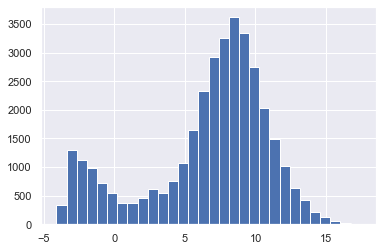

In [21]:
plt.hist(bpm_filt_expr_df.values.flatten(),bins=30)

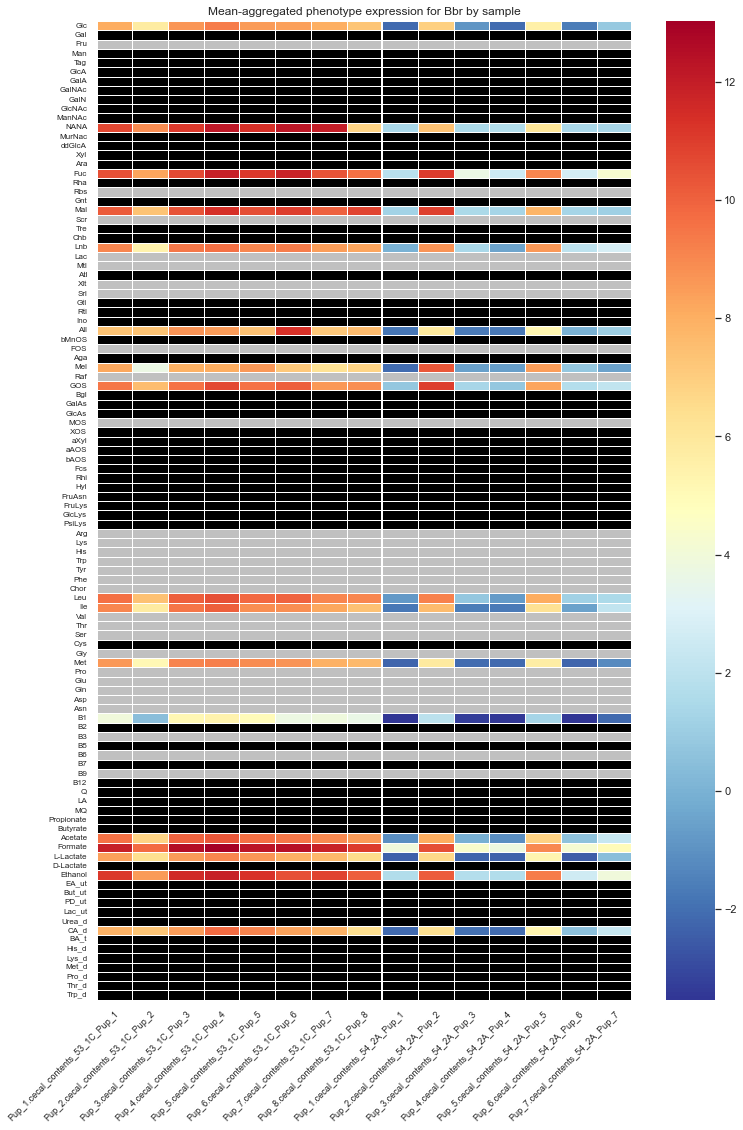

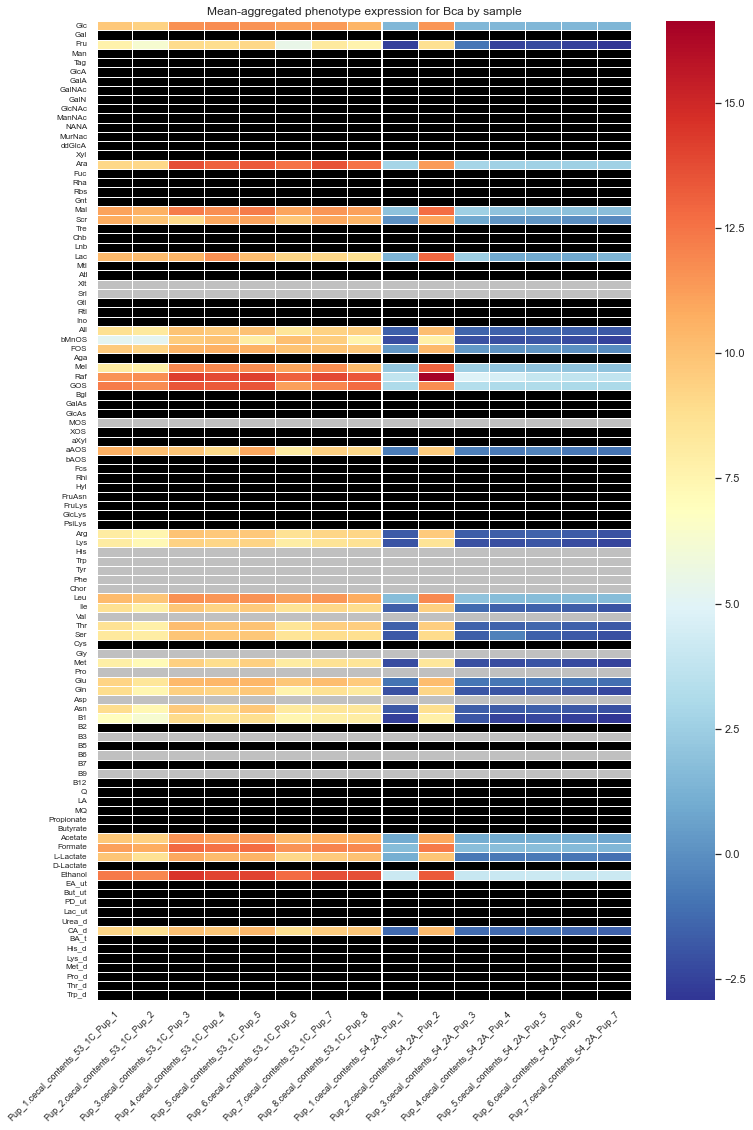

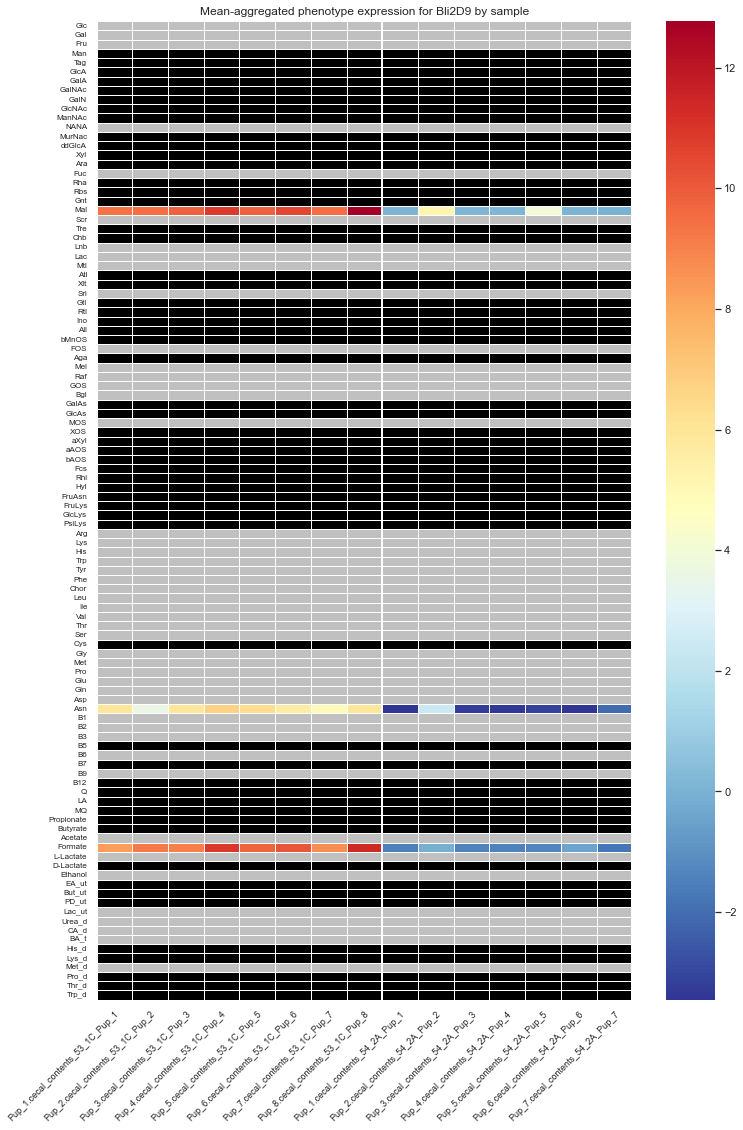

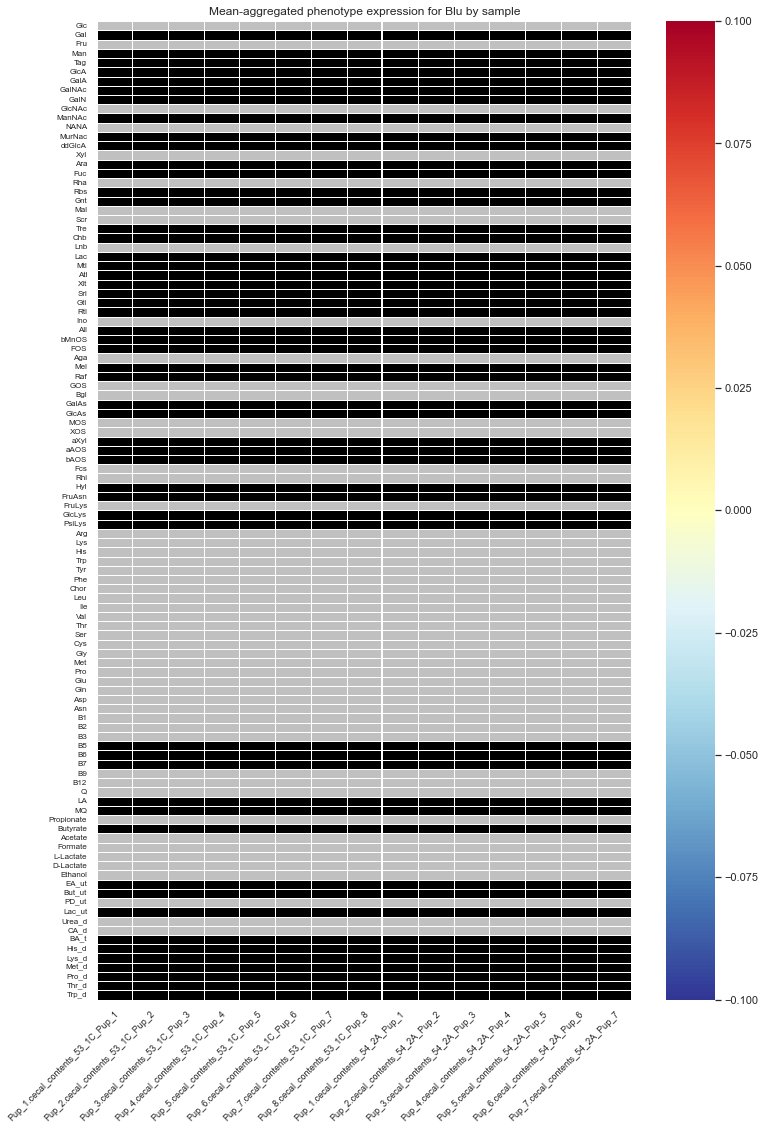

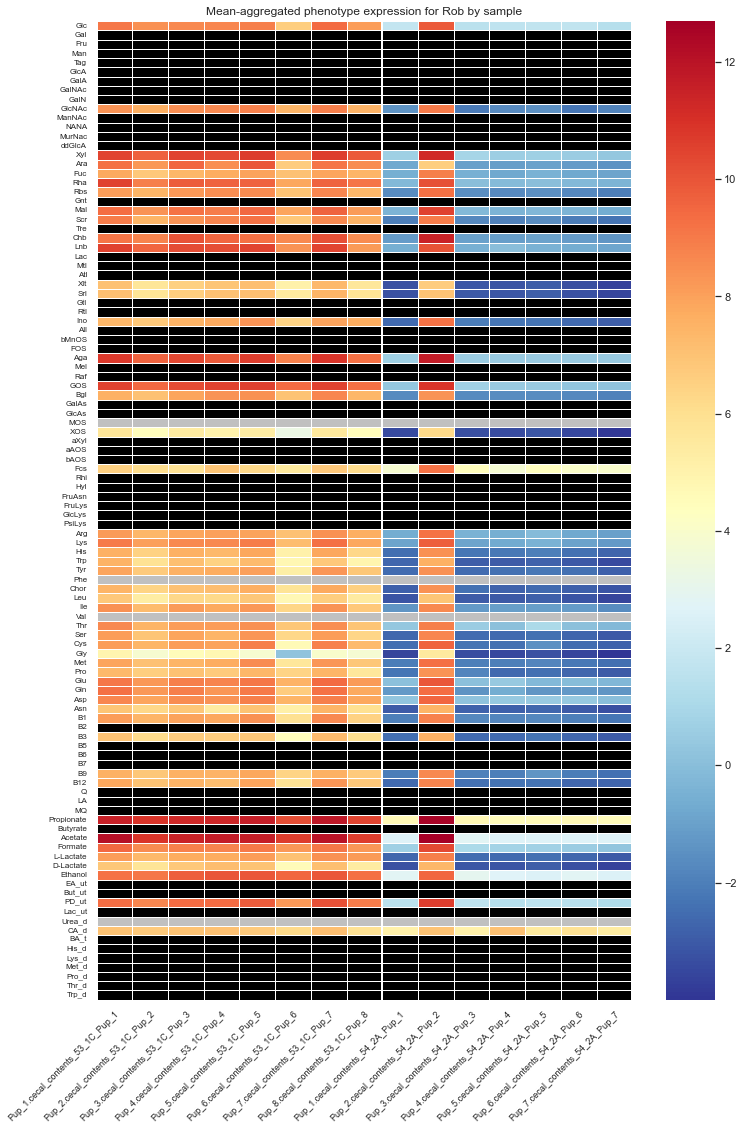

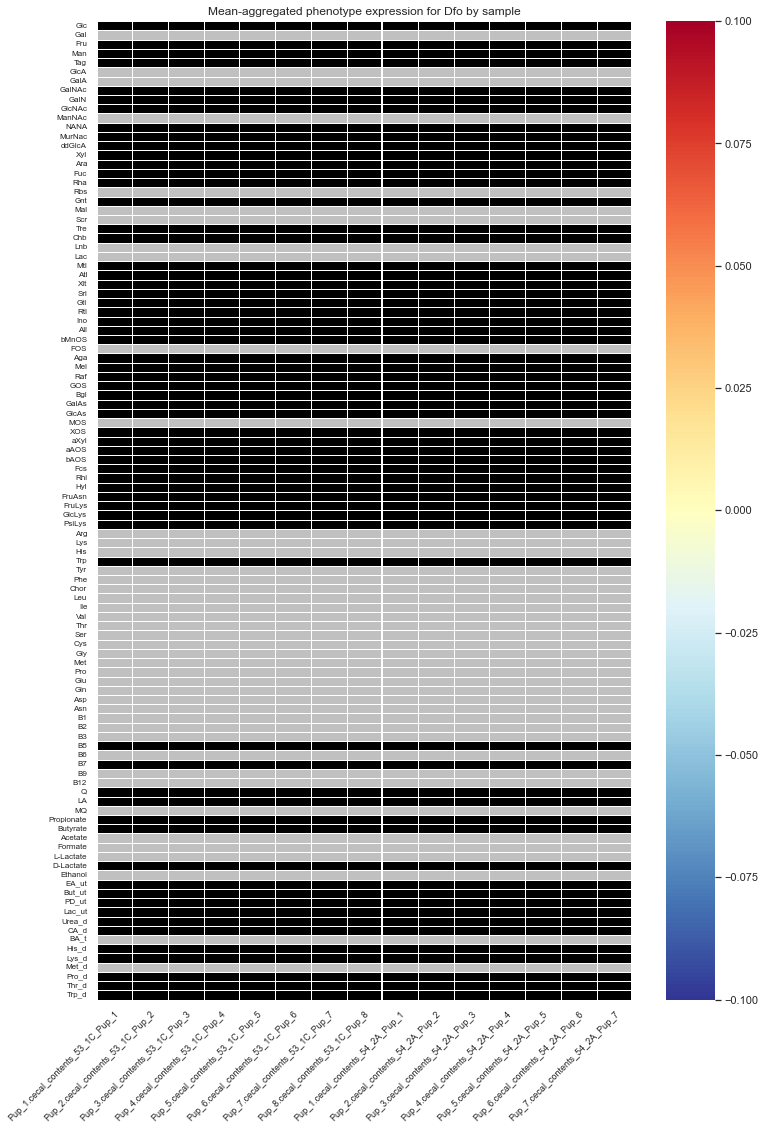

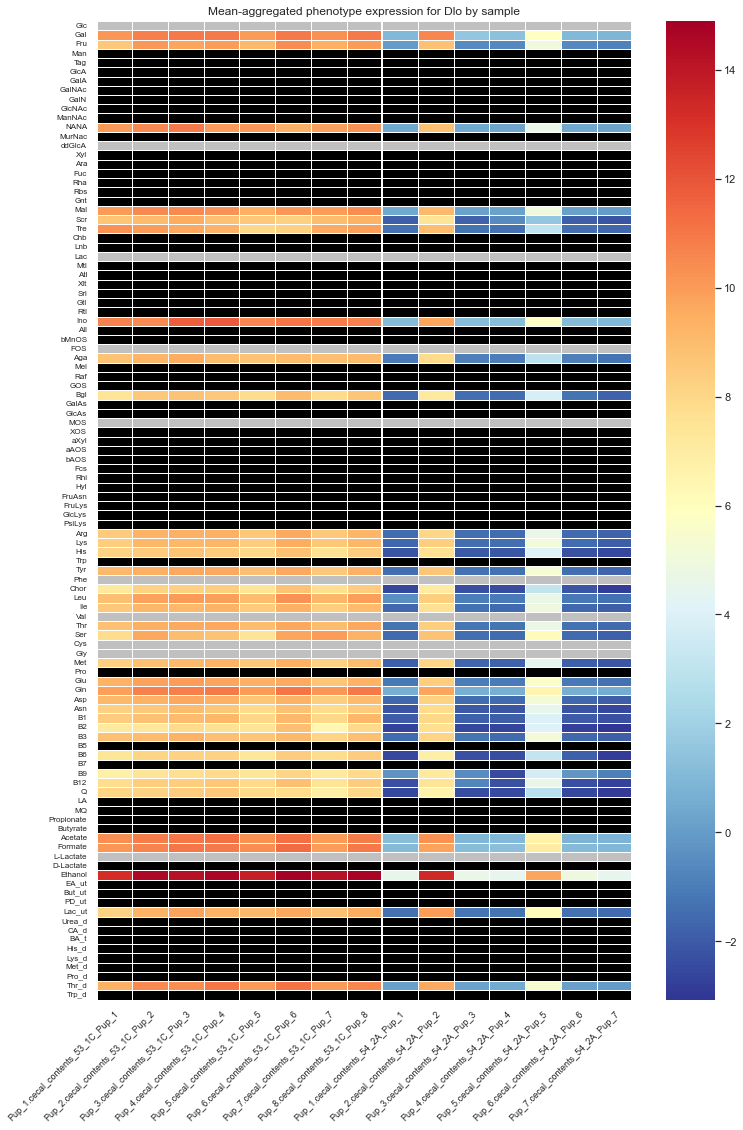

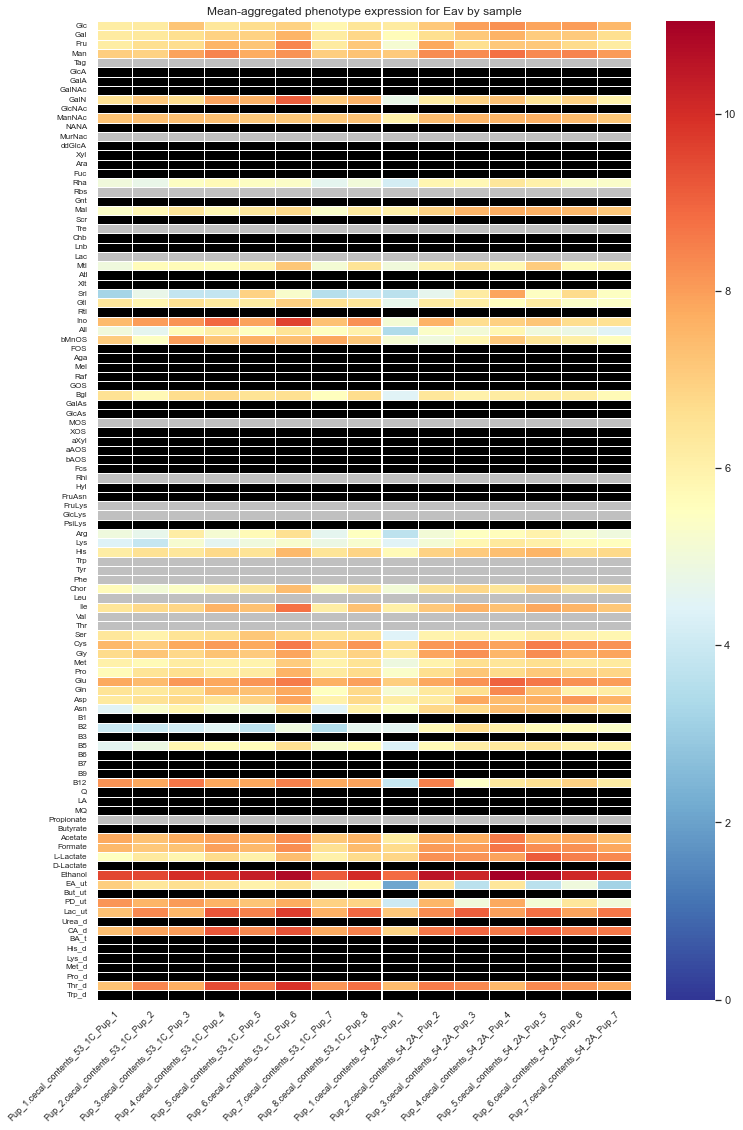

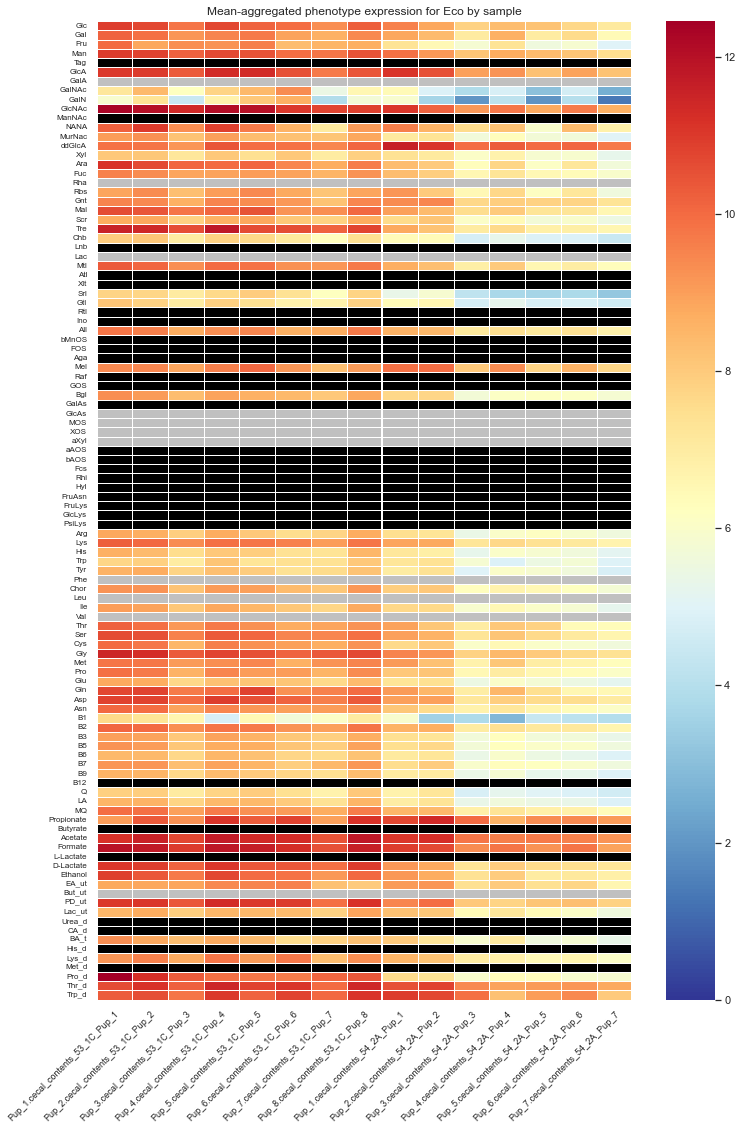

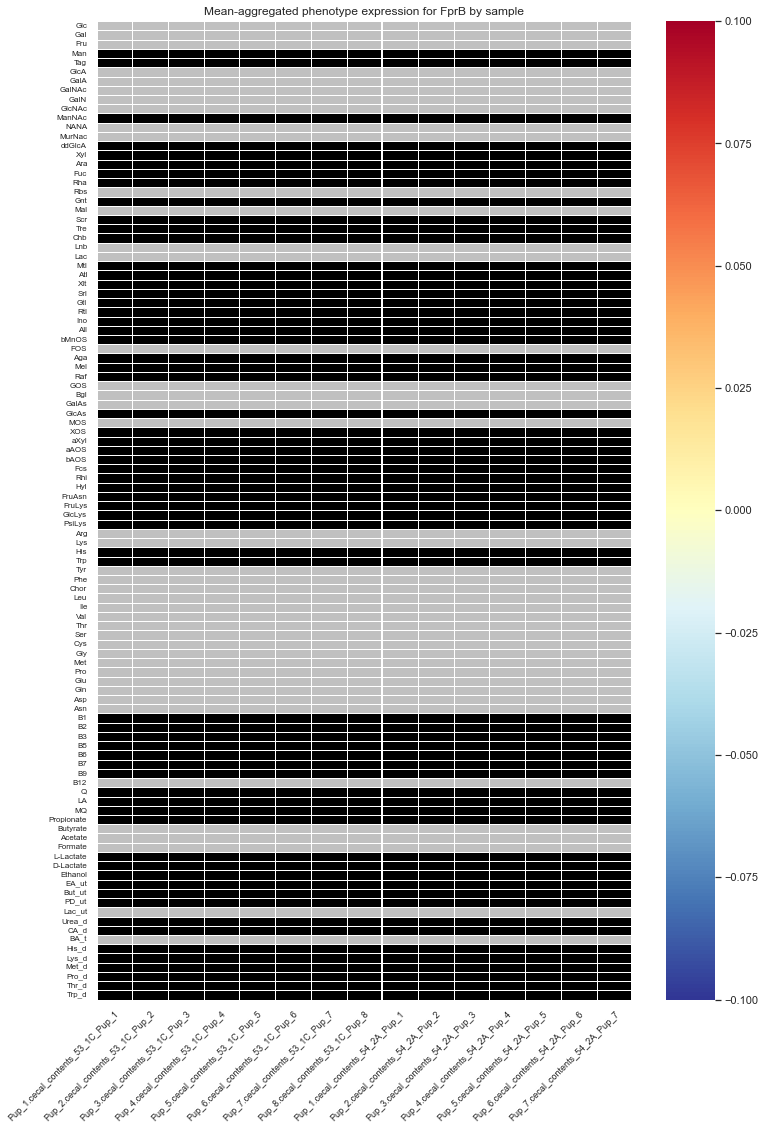

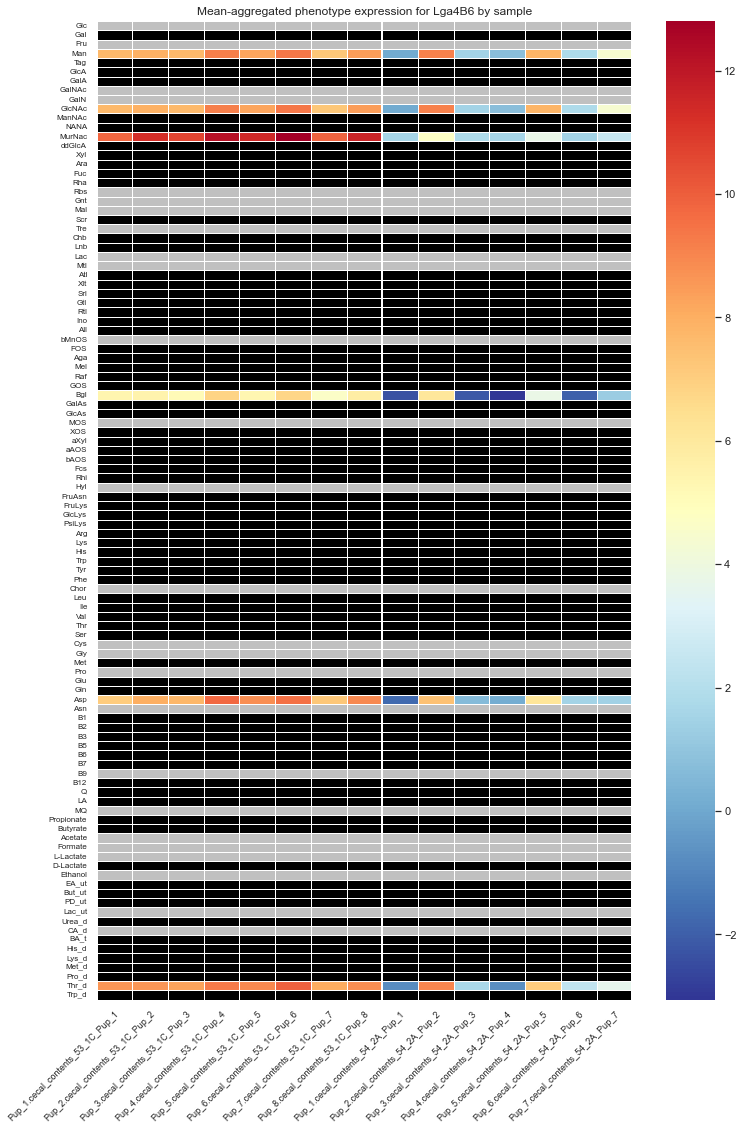

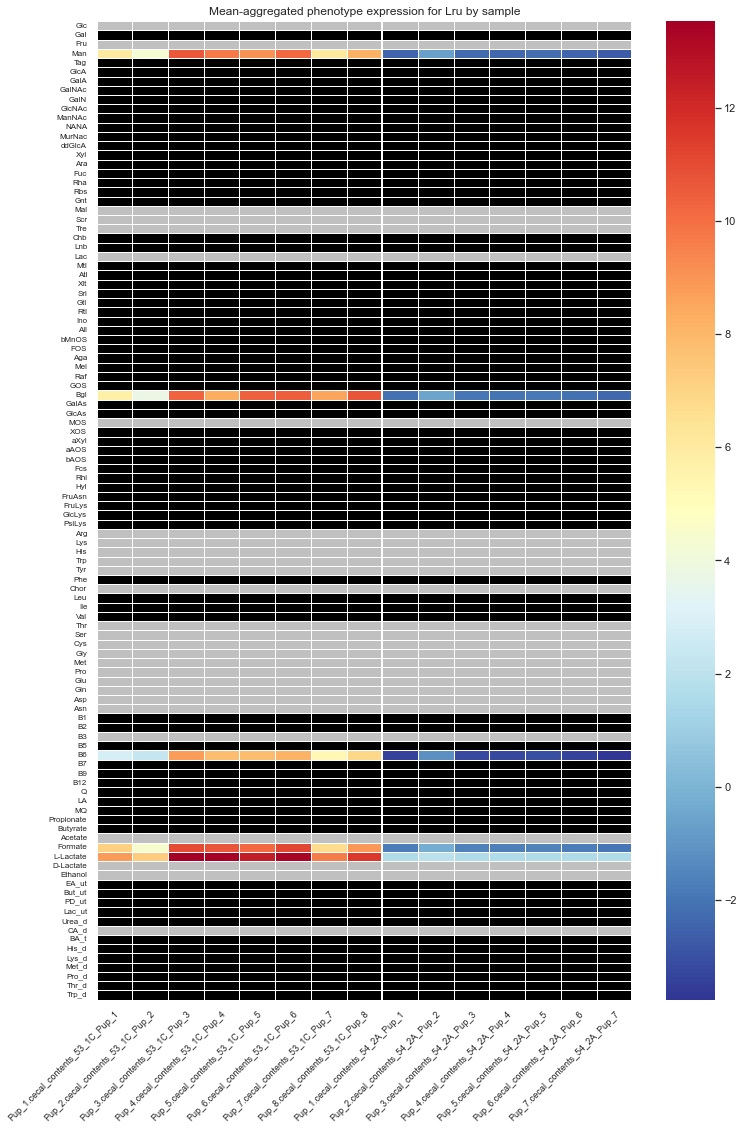

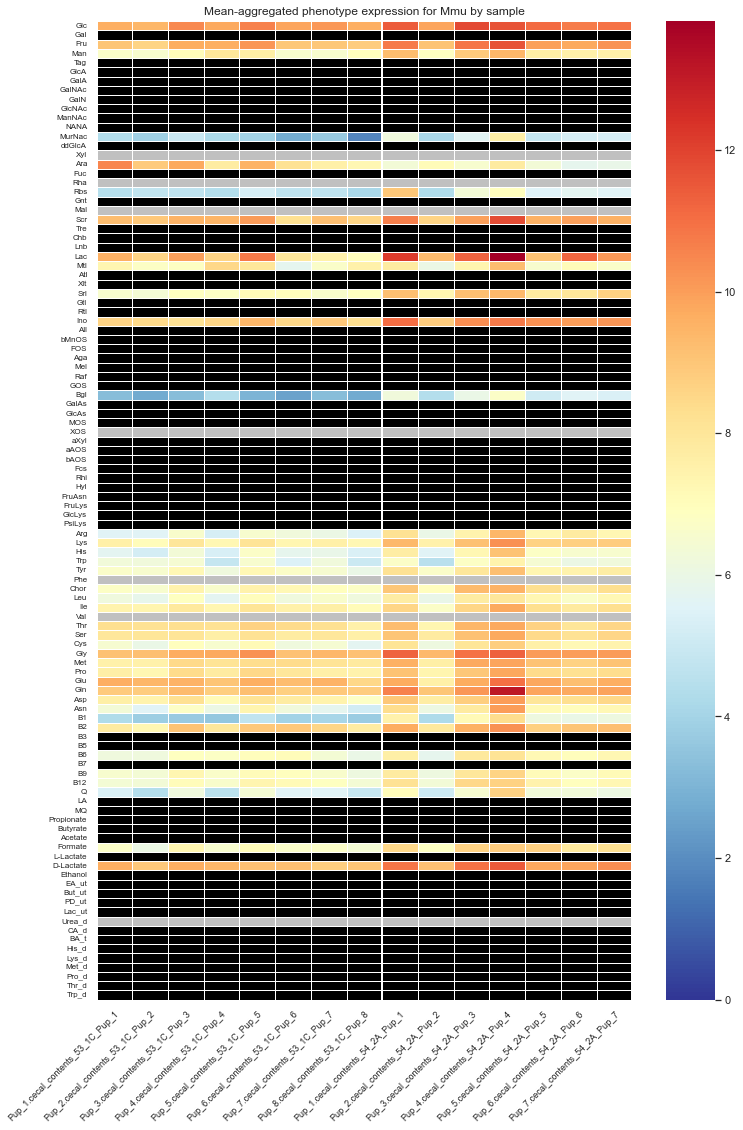

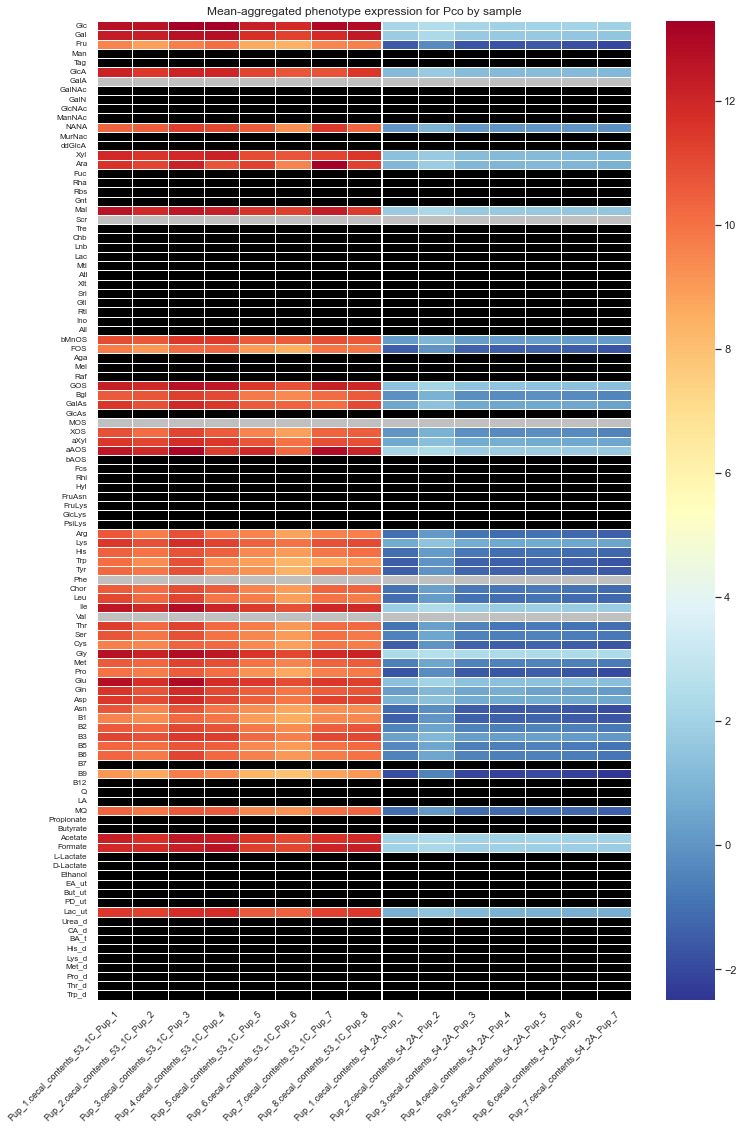

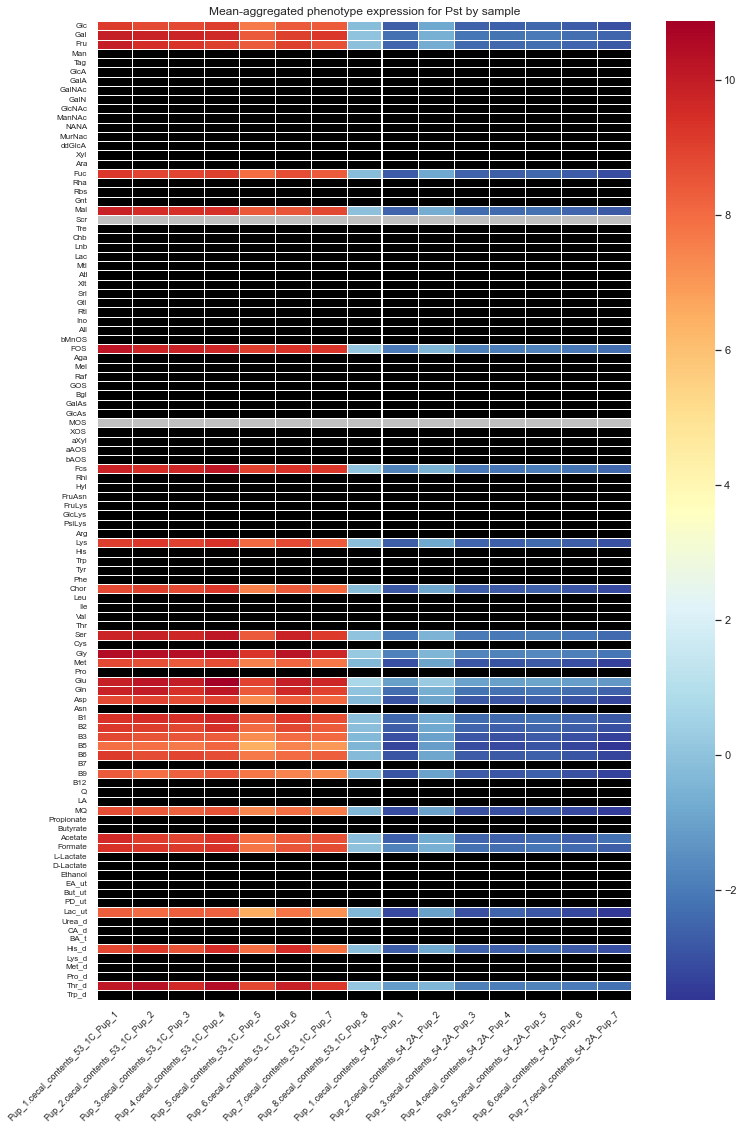

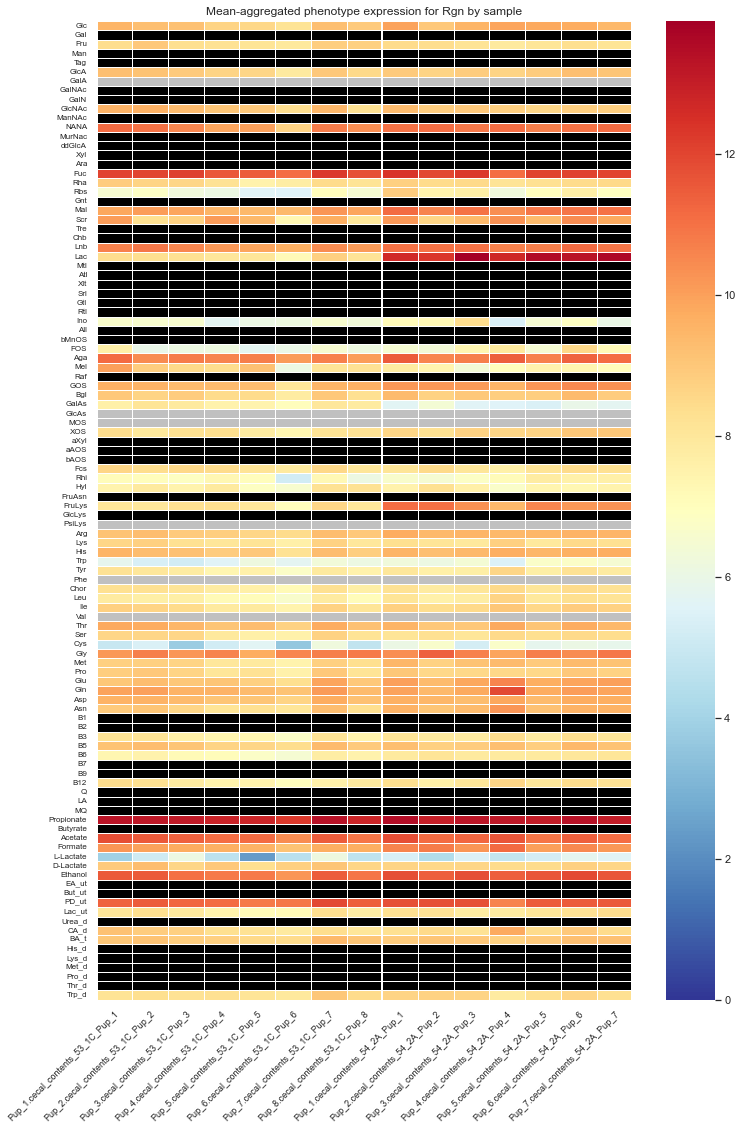

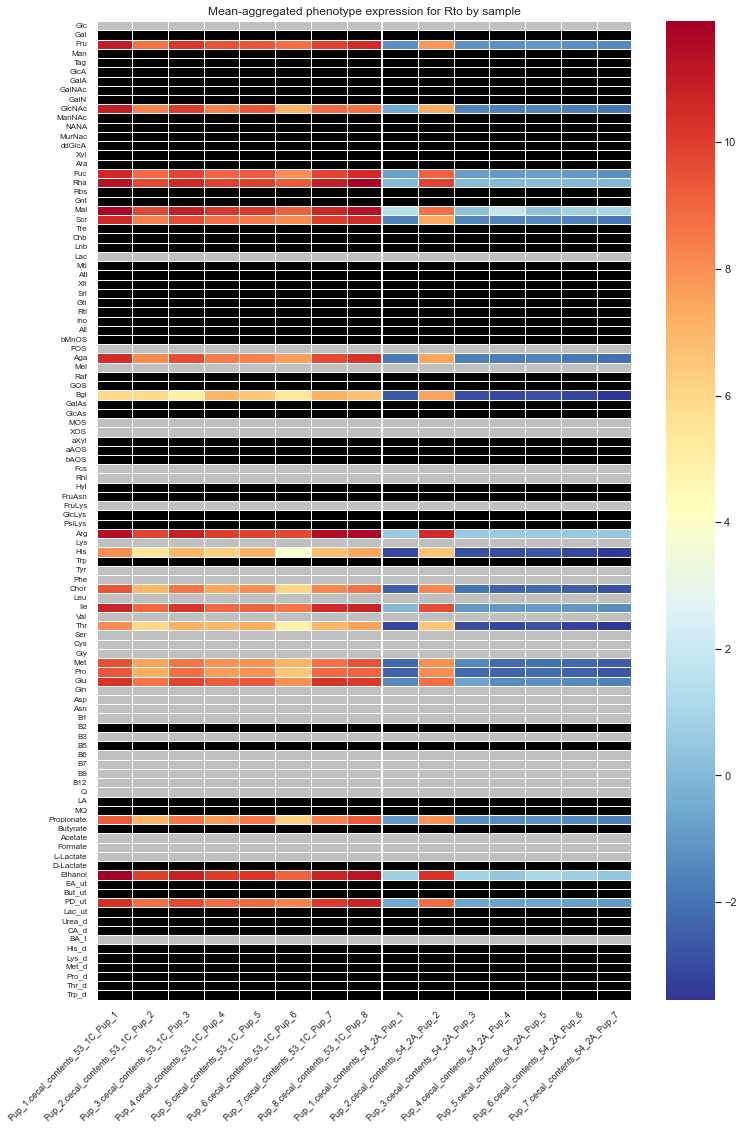

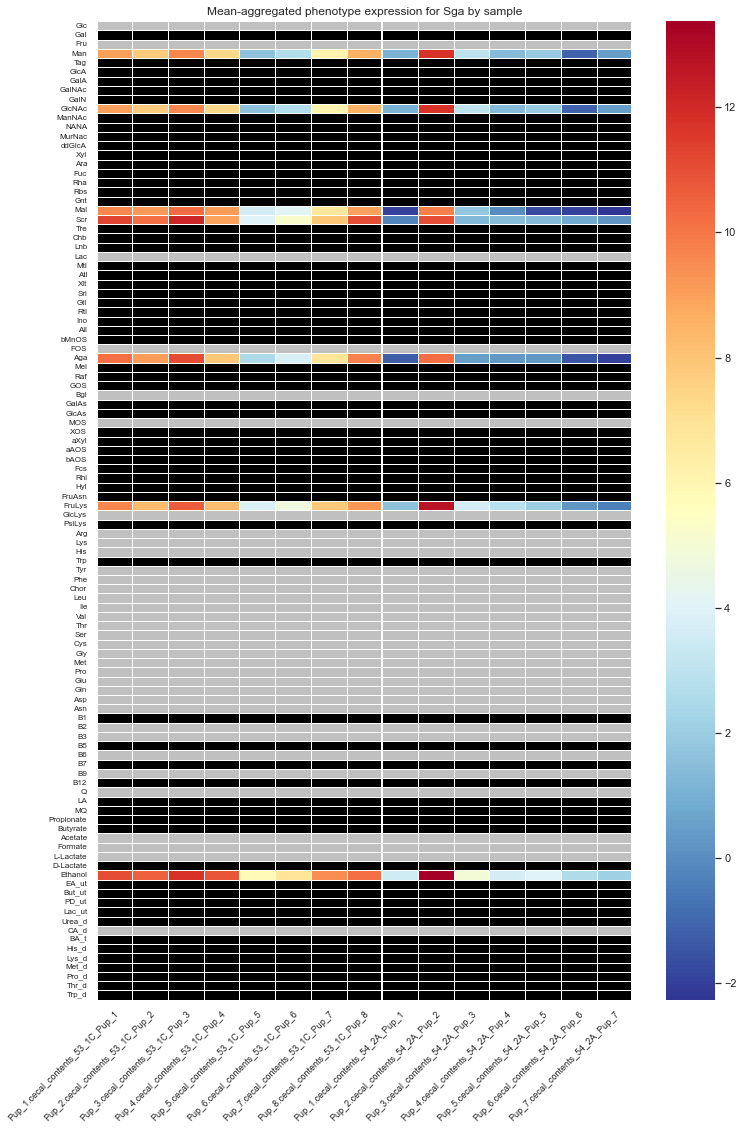

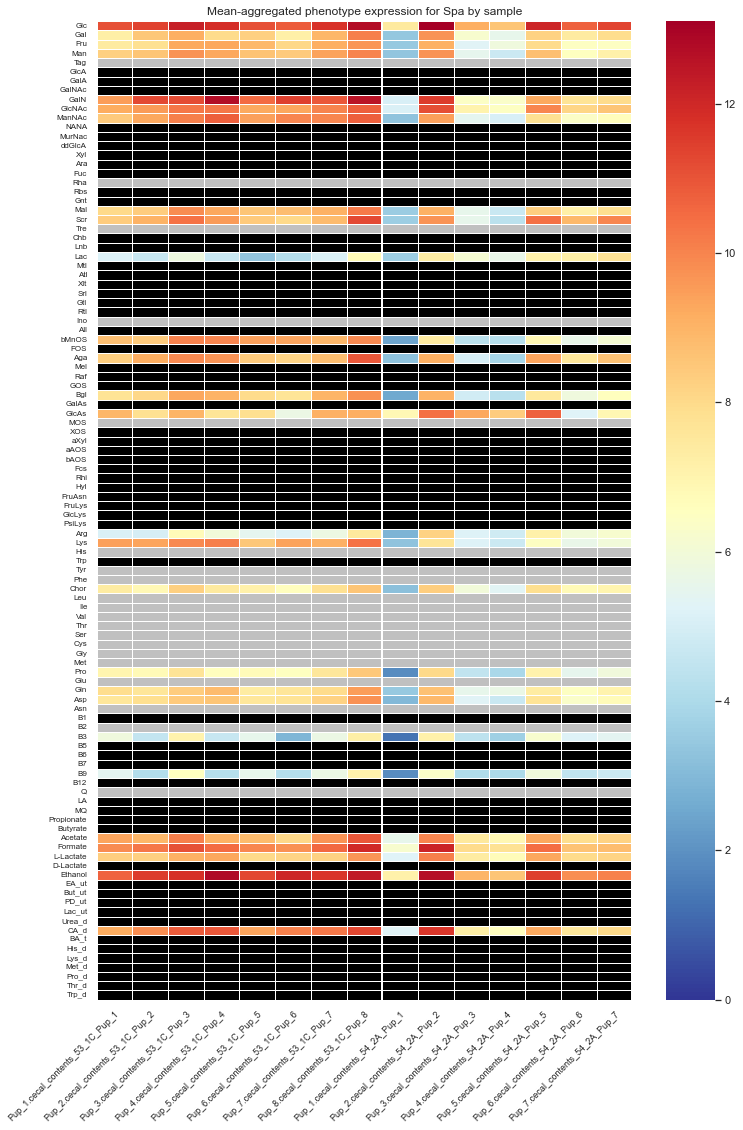

In [23]:
#tpm based sample pht aggregation dataframes 
#sample_pht_expr_dfs = per_sample_pht_aggregation(tpm_df,bpm_df,mcseed_df)

#Sample_pht_aggregation dataframes 
sample_pht_expr_dfs = per_sample_pht_aggregation(filt_expr_df,bpm_df,mcseed_df,agg_method="mean")

#Use sample_pht_expr_dfs to construct phenotype x sample heatmaps for each strain
#Mostly exploratory analysis - assess which strains have phenotype aggregated signal that is 1) present and 
#2) differentiates the Pco and no Pco arms (in cecal and/or ileal samples)

strain_pht_expr_index, strain_pht_expr_cols = bpm_df.index, filt_expr_df.columns
strain_figs = "{0}/strains".format(figures_dir)
if not os.path.exists(strain_figs):
    os.makedirs(strain_figs)

for strain in STRAIN_TAGS:
    strain_abbrev = STRAIN_TAGS[strain]
    strain_sample_pht_expr_df = pd.DataFrame(index=strain_pht_expr_index,columns=strain_pht_expr_cols)

    for sample in sample_pht_expr_dfs: 
        sample_pht_expr_df = sample_pht_expr_dfs[sample]
        strain_sample_pht_expr_df.loc[:,sample] = sample_pht_expr_df.loc[:,strain]
#     display(strain_sample_pht_expr_df)

    #Reorder columns by 1: cecal contents then ileal; 2: Study Arm (1C = Pre-weaning Pco vs 2A = No Pco)
    cols_1C_arr, cols_2A_arr = [strain_sample_pht_expr_df.columns.str.contains(tag) for tag in ["1C","2A"]] #boolean arrays 
    cols_1C, cols_2A = [strain_sample_pht_expr_df.columns[cols] for cols in [cols_1C_arr,cols_2A_arr]]#filtered column lists 
    cols_1C_cecal_arr, cols_1C_ileal_arr = [cols_1C.str.contains(tag) for tag in ["cecal","ileal"]] #boolean_arrays
    cols_1C_cecal, cols_1C_ileal = [cols_1C[cols_1C_cecal_arr],cols_1C[cols_1C_ileal_arr]] #filtered columns
    cols_2A_cecal_arr, cols_2A_ileal_arr = [cols_2A.str.contains(tag) for tag in ["cecal","ileal"]] #boolean arrays
    cols_2A_cecal, cols_2A_ileal = [cols_2A[cols_2A_cecal_arr],cols_2A[cols_2A_ileal_arr]]
    n_1C_cecal, n_1C_ileal, n_2A_cecal, n_2A_ileal = [len(cols) for cols in [cols_1C_cecal,cols_1C_ileal,
                                                                            cols_2A_cecal,cols_2A_ileal]]
    reordered_cols = pd.Index(list(cols_1C_cecal)+list(cols_2A_cecal)+list(cols_1C_ileal)+list(cols_2A_ileal))
    strain_sample_pht_expr_df = strain_sample_pht_expr_df.loc[:,reordered_cols]

    strain_pht_heatmap_mask = pd.DataFrame(index=strain_sample_pht_expr_df.index, columns=strain_sample_pht_expr_df.columns)
    strain_pht_heatmap_mask.loc[:,:] = False
    strain_pht_heatmap_mask.loc[bpm_df.loc[:,strain]==True,:] = True

#     display(strain_pht_heatmap_mask)

    #Heat map of strain data 
    import os 
    if not os.path.exists("figures"):
        os.makedirs("figures")

    fig = plt.figure(figsize=(12,18))
    fig.tight_layout()
    plt.title("Mean-aggregated phenotype expression for {0} by sample".format(strain_abbrev),fontsize=12)
    sns.set(font_scale=1.0)

    g = sns.heatmap(strain_sample_pht_expr_df,cmap="RdYlBu_r",linewidths=.5,xticklabels=True,yticklabels=True)
    #Black-mask BPM negative rows using strain_pht_heatmap_mask
    g2= sns.heatmap(strain_pht_heatmap_mask.astype(int),cmap="Greys",vmin=-1,vmax=0,mask=strain_pht_heatmap_mask,
                    linewidths=0.5,cbar=False,yticklabels=True)
    cecal_ileal_vline = n_1C_cecal + n_2A_cecal
    g.vlines([cecal_ileal_vline],*g.get_ylim(),color="white",linewidth=3)
    arm_vlines = [n_1C_cecal,n_1C_cecal+n_1C_ileal+n_2A_cecal]
    g.vlines(arm_vlines,*g.get_ylim(),color="white",linewidth=2)
    g.set_yticklabels(g.get_yticklabels(),fontsize =8)
    g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right', rotation_mode='anchor',fontsize=9)
    # g.set_facecolor("#FFFFFF")
    g.set_facecolor("#C0C0C0")

    plt.savefig("{0}/{1}_sample_heatmap_filt_log.png".format(strain_figs,strain_abbrev),
                dpi=200, facecolor='w',bbox_inches="tight")


In [23]:
display(strain_sample_pht_expr_df)

,Pup_1.cecal_contents_53_1C_Pup_1,Pup_2.cecal_contents_53_1C_Pup_2,Pup_3.cecal_contents_53_1C_Pup_3,Pup_4.cecal_contents_53_1C_Pup_4,Pup_5.cecal_contents_53_1C_Pup_5,Pup_6.cecal_contents_53_1C_Pup_6,Pup_7.cecal_contents_53_1C_Pup_7,Pup_8.cecal_contents_53_1C_Pup_8,Pup_1.cecal_contents_54_2A_Pup_1,Pup_2.cecal_contents_54_2A_Pup_2,...,Pup_6.ileal_contents_53_1C_Pup_6,Pup_7.ileal_contents_53_1C_Pup_7,Pup_8.ileal_contents_53_1C_Pup_8,Pup_1.ileal_contents_54_2A_Pup_1,Pup_2.ileal_contents_54_2A_Pup_2,Pup_3.ileal_contents_54_2A_Pup_3,Pup_4.ileal_contents_54_2A_Pup_4,Pup_5.ileal_contents_54_2A_Pup_5,Pup_6.ileal_contents_54_2A_Pup_6,Pup_7.ileal_contents_54_2A_Pup_7
Glc,7.273856,7.743747,7.804292,6.551223,6.398761,5.717357,7.611397,8.196464,5.595083,9.083541,...,4.692265,6.293604,6.773195,6.198682,8.673530,5.298817,4.906015,9.295150,8.209880,7.680684
Gal,5.539429,6.155163,6.182501,5.146200,4.625162,4.593079,6.288300,6.980514,4.161903,7.067693,...,3.061957,5.161074,5.460249,5.158011,6.474677,5.107194,4.451925,7.671941,6.954167,6.527553
Fru,4.647585,5.209511,5.705775,4.837239,4.959171,3.928771,5.823048,5.975276,3.355477,6.128034,...,3.854096,4.811413,5.086461,4.893722,7.144974,4.870183,4.527793,8.044019,7.295322,6.279401
Man,6.186703,6.564240,6.697173,5.736576,5.466802,5.019607,6.611285,6.884714,3.711151,7.336776,...,3.760219,5.296294,5.311216,4.591866,6.957712,4.173254,2.927646,7.592974,6.292717,5.777717
Tag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lys_d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Met_d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pro_d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Thr_d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
